In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# Import property data
data = pd.read_excel('Property Data Compiled.xlsx', index_col = 0)

In [3]:
#  Check rows and column numbers in data
data.shape

(20363, 211)

In [4]:
# List of Columns
data.columns.tolist()

['PropID',
 'Property Address',
 'Property Name',
 'Star Rating',
 'Energy Star',
 'LEED Certified',
 'Building Status',
 'Secondary Type',
 'Market Name',
 'Submarket Name',
 'City',
 'State',
 'Zip',
 'County Name',
 'For Sale Price',
 'For Sale Status',
 'Land Area (AC)',
 'Number Of Stories',
 'Style',
 'Number Of Units',
 '$Price/Unit',
 'Cap Rate',
 'Vacancy %',
 'Avg Unit SF',
 'Avg Asking/Unit',
 'Avg Asking/SF',
 'Avg Effective/Unit',
 'Avg Effective/SF',
 'Avg Concessions %',
 '% Studios',
 '% 1-Bed',
 '% 2-Bed',
 '% 3-Bed',
 '% 4-Bed',
 'Rent Type',
 'Affordable Type',
 'Market Segment',
 'Parking Spaces/Unit',
 'Number Of Parking Spaces',
 'Days On Market',
 'Amenities',
 'Number Of 1 Bedrooms',
 'Number Of 2 Bedrooms',
 'Number Of 3 Bedrooms',
 'Number Of 4 Bedrooms',
 'Architect Name',
 'Building Class',
 'Building Park',
 'Closest Transit Stop',
 'Closest Transit Stop Dist (mi)',
 'Closest Transit Stop Walk Time (min)',
 'Construction Material',
 'Developer Name',
 'Feat

## 1. Data Cleaning
Create a subset of original data based on EDA to reduce calculation load. Drop duplicates. Get 5 digit zip & Fix State typo.

In [5]:
cols = ['PropertyID', 
        # rent fields
        'Avg Effective/SF', 'Avg Concessions %',
        'Studio Effective Rent/SF', 'One Bedroom Effective Rent/SF', 'Two Bedroom Effective Rent/SF',
        'Three Bedroom Effective Rent/SF', 'Four Bedroom Effective Rent/SF',
        # unit fields
        'Studio Avg SF', 'Number Of Studios', 'Studio Vacant Units', 'Studio Vacancy %',
        'One Bedroom Avg SF','Number Of 1 Bedrooms', 'One Bedroom Vacant Units', 'One Bedroom Vacancy %',
        'Two Bedroom Avg SF', 'Number Of 2 Bedrooms', 'Two Bedroom Vacant Units', 'Two Bedroom Vacancy %',
        'Three Bedroom Avg SF', 'Number Of 3 Bedrooms', 'Three Bedroom Vacant Units', 'Three Bedroom Vacancy %',
        'Four Bedroom Avg SF', 'Number Of 4 Bedrooms', 'Four Bedroom Vacant Units', 'Four Bedroom Vacancy %',        
        # location fields
        'State', 'Market Name', 'City', 'Zip', 'County Name',
        'Closest Transit Stop Dist (mi)', 'Latitude', 'Longitude',
        # property fields
        'Star Rating', 'Building Status', 'Land Area (AC)', 'Number Of Stories',
        'Style', 'Number Of Units', 'Vacancy %', 'Avg Unit SF', 'RBA',
        '% Studios', '% 1-Bed', '% 2-Bed', '% 3-Bed', '% 4-Bed',
        'Rent Type', 'Affordable Type', 'Construction Material', 
        'Amenities', 'Owner Name', 'Year Built', 'Year Renovated',
        # demographic fields
        '2019 Avg Age(1m)', '2019 Pop Age <19(1m)', '2019 Pop Age 20-64(1m)','2019 Pop Age 65+(1m)']
sub = data.copy()[cols]
sub.drop_duplicates(subset='PropertyID', inplace = True)
sub['Zip5'] = sub['Zip'].str[:5]
sub['State'] = sub['State'].map({'TX':'TX',
                                 'FL':'FL',
                                 'GA':'GA',
                                 'NC':'NC',
                                 'Fl':'FL',
                                 'NC ':'NC'})
sub.shape

(20300, 62)

In [6]:
# Export unique zip codes
pd.DataFrame(sub['Zip5'].unique()).to_csv('Zip5.csv',index=False)

In [7]:
# Check data type and missing values for each of the variables
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20300 entries, 1 to 20363
Data columns (total 62 columns):
PropertyID                         20300 non-null int64
Avg Effective/SF                   16751 non-null float64
Avg Concessions %                  20300 non-null float64
Studio Effective Rent/SF           2475 non-null float64
One Bedroom Effective Rent/SF      15360 non-null float64
Two Bedroom Effective Rent/SF      16207 non-null float64
Three Bedroom Effective Rent/SF    10031 non-null float64
Four Bedroom Effective Rent/SF     1401 non-null float64
Studio Avg SF                      2934 non-null float64
Number Of Studios                  3041 non-null float64
Studio Vacant Units                2588 non-null float64
Studio Vacancy %                   2588 non-null float64
One Bedroom Avg SF                 16910 non-null float64
Number Of 1 Bedrooms               17326 non-null float64
One Bedroom Vacant Units           15815 non-null float64
One Bedroom Vacancy %        

### 1.1 Drop properties that are proposed, under construction or demolished

In [8]:
# Number of rows for each building status
sub['Building Status'].value_counts()

Existing              17934
Proposed                964
Under Construction      811
Demolished              365
Under Renovation        226
Name: Building Status, dtype: int64

In [9]:
# Remove rows belonging to proposed, under construction and demolished categories
row_initial = sub.shape[0]
sub = sub[sub['Building Status'].isin(['Existing','Under Renovation'])].copy()
print('Records dropped:', row_initial - sub.shape[0])
print('Current size:', sub.shape)

Records dropped: 2140
Current size: (18160, 62)


### 1.2 Drop properties that are missing Avg Effective/SF (which is our output variable i.e. final rent price/sqft)
Almost all records missing Avg Effective/SF are missing Effective Rent/SF for specifi unit types too, so cannot be calculated and filled and have to be dropped.

In [10]:
# Calculate how much data is missing for avg effective/sf
print('Percentage of data missing Avg Effective/SF:',1-sub['Avg Effective/SF'].count()/sub.shape[0])

Percentage of data missing Avg Effective/SF: 0.08838105726872247


In [11]:
# When overal rent/SF is missing, detailed rents by unit types are usually missing too
# The first can't be calculated and filled from the latter
sub[sub['Avg Effective/SF'].isnull()][['Studio Effective Rent/SF', 'One Bedroom Effective Rent/SF', 
                                       'Two Bedroom Effective Rent/SF','Three Bedroom Effective Rent/SF', 
                                       'Four Bedroom Effective Rent/SF']].count()

Studio Effective Rent/SF           0
One Bedroom Effective Rent/SF      1
Two Bedroom Effective Rent/SF      2
Three Bedroom Effective Rent/SF    1
Four Bedroom Effective Rent/SF     0
dtype: int64

In [12]:
# Drop the rows where avg effective/SF is missing
row_initial = sub.shape[0]
sub = sub[sub['Avg Effective/SF'].notnull()].copy()
print('Records dropped:', row_initial - sub.shape[0])
print('Current size:', sub.shape)

Records dropped: 1605
Current size: (16555, 62)


### 1.3 Validate property unit mix
### 1.3.1 Fix wrong data in % 4-Bed
Most records have % room types that don't add up to 100. Reason is that Column '% 4-Bed' is not consistent with other % room type columns. Multiply all '% 4-Bed' by 100 to make it consistent.

In [13]:
# Multiply % 4-Bed by 100 to make data consistent
# Create a % total column to see if all % columns add up to 100
sub['% 4-Bed'] = sub['% 4-Bed']*100
sub['% tot'] = sub[['% Studios', '% 1-Bed', '% 2-Bed', '% 3-Bed', '% 4-Bed']].sum(axis=1)
sub['% tot'] = sub['% tot'].apply(round)
sub['% tot'].value_counts()

100    16518
0         37
Name: % tot, dtype: int64

Some % tot still add up to suggesting missing data. Let's dig deeper into different units and understand this.

### 1.3.2 Fill missing value in % Studios/1-Bed/2-Bed/3-Bed/4-Bed
Some records have Number Of Studios value but no % Studios value. Fill missing value with Number Of Studios divided by Number Of Units. Do the same for 1/2/3/4 bedrooms.

In [14]:
# Fill missing values in % of unit types with values calculated from other fields
unit_type = {'Studios':'Studios', '1 Bedrooms':'1-Bed', 
             '2 Bedrooms':'2-Bed', '3 Bedrooms':'3-Bed', '4 Bedrooms':'4-Bed'}

for utype in unit_type.keys():
    sub['% {}'.format(unit_type[utype])] =\
    sub[['% {}'.format(unit_type[utype]), 'Number Of {}'.format(utype), 'Number Of Units']].\
    apply(lambda x: x[0] if np.isnan(x[0])==False else(\
    x[0] if np.isnan(x[1]) else x[1]/x[2]*100), axis=1)

### 1.3.3 Fill missing value in Number Of Studios/1-Bed/2-Bed/3-Bed/4-Bed
Some records have % Studios values but no Number Of Studios value. Fill missing value with number of total unit X % Studios. Do the same for 1/2/3/4 bedrooms.

In [15]:
# Fill missing values in numbers of unit types with values calculated from other fields
for utype in unit_type.keys():
    sub['Number Of {}'.format(utype)] = sub[['Number Of {}'.format(utype), '% {}'.format(unit_type[utype]), 
                                             'Number Of Units']].\
                                        apply(lambda x: x[1] * x[2]/100 if np.isnan(x[0]) else x[0], axis=1)

### 1.3.4 Check if % unit types add up to 100 , fix wrong numbers
Let's come back to % tot to validate number of different units add up.

In [16]:
# Recheck % total to see if there are still non-100s
sub['% tot'] = sub[['% Studios', '% 1-Bed', '% 2-Bed', '% 3-Bed', '% 4-Bed']].sum(axis=1)
sub['% tot'] = sub['% tot'].apply(round)
sub['% tot'].value_counts()

100    16544
101        3
145        2
200        1
71         1
166        1
86         1
164        1
112        1
Name: % tot, dtype: int64

In [17]:
# Find rows that don't add up to 100 
wrong = sub['% tot'].value_counts().index.tolist()
wrong.remove(100)
sub[sub['% tot'].isin(wrong)][['Studio Effective Rent/SF', 'One Bedroom Effective Rent/SF', 
                               'Two Bedroom Effective Rent/SF','Three Bedroom Effective Rent/SF', 
                               'Four Bedroom Effective Rent/SF',
                               '% Studios', '% 1-Bed', '% 2-Bed', '% 3-Bed', '% 4-Bed',
                               'Number Of Studios', 'Number Of 1 Bedrooms', 'Number Of 2 Bedrooms', 
                               'Number Of 3 Bedrooms', 'Number Of 4 Bedrooms', 'Number Of Units']].head(11)

,Studio Effective Rent/SF,One Bedroom Effective Rent/SF,Two Bedroom Effective Rent/SF,Three Bedroom Effective Rent/SF,Four Bedroom Effective Rent/SF,% Studios,% 1-Bed,% 2-Bed,% 3-Bed,% 4-Bed,Number Of Studios,Number Of 1 Bedrooms,Number Of 2 Bedrooms,Number Of 3 Bedrooms,Number Of 4 Bedrooms,Number Of Units
Row,,,,,,,,,,,,,,,,
835,NaN,NaN,NaN,NaN,0.64,NaN,NaN,NaN,NaN,71.282051,NaN,NaN,NaN,NaN,139.0000,195
924,0.51,1.02,0.78,0.82,NaN,1.123596,44.380000,46.630000,8.990000,NaN,4.0,158.0,166.0,28.0000,NaN,356
941,NaN,NaN,NaN,NaN,1.04,NaN,NaN,NaN,NaN,85.789474,NaN,NaN,NaN,NaN,163.0000,190
1677,NaN,0.73,0.51,0.49,NaN,NaN,11.594203,59.420000,40.580000,NaN,NaN,16.0,82.0,40.0000,NaN,138
4064,1.71,1.99,1.96,NaN,NaN,22.540000,45.081967,54.920000,22.540000,NaN,55.0,110.0,79.0,54.9976,NaN,244
5497,NaN,1.62,1.37,1.24,NaN,100.000000,28.571429,57.142857,14.285714,NaN,336.0,96.0,192.0,48.0000,NaN,336
6137,1.34,NaN,0.65,0.44,NaN,45.000000,45.000000,45.000000,10.000000,NaN,45.0,45.0,45.0,10.0000,NaN,100
8089,NaN,NaN,1.43,1.59,1.65,NaN,86.710000,10.490000,2.800000,65.734266,NaN,30.0,15.0,4.0000,94.0000,143
11073,NaN,0.95,0.92,0.80,NaN,NaN,63.960000,36.040000,0.900901,NaN,NaN,71.0,39.0,1.0000,NaN,111


Row 11401 can be easily fixed by removing number of 4 bedrooms and % 4-Bed.

In [18]:
# Fix row 11401
sub.loc[11401, 'Number Of 4 Bedrooms']=np.nan
sub.loc[11401, '% 4-Bed']=np.nan

Find the rows where number of units add up and fix their % accordingly. Drop the rows where number of units don't add up.

In [19]:
# Find rows where absolute numbers do and do not add up
test = sub[sub['% tot'].isin(wrong)]
ind = pd.DataFrame(test[['Number Of Studios', 'Number Of 1 Bedrooms', 'Number Of 2 Bedrooms', 
                         'Number Of 3 Bedrooms', 'Number Of 4 Bedrooms']].\
                   sum(axis=1)==test['Number Of Units']).reset_index()
ind.columns=['Row','match']
match = ind[ind['match']==True]['Row'].tolist()
unmatch = ind[ind['match']==False]['Row'].tolist()
print('Matched:', match)
print('Unmatched:', unmatch)

Matched: [924, 1677, 8089, 11073, 11401, 12945]
Unmatched: [835, 941, 4064, 5497, 6137]


In [20]:
# Remove unmatched rows
# For matched ones, recalculate the % based on absolute number of units
unit_type = {'Studios':'Studios', '1 Bedrooms':'1-Bed', 
             '2 Bedrooms':'2-Bed', '3 Bedrooms':'3-Bed', '4 Bedrooms':'4-Bed'}
for utype in unit_type.keys():
    sub.loc[match,'% {}'.format(unit_type[utype])] =\
    sub.loc[match, ['% {}'.format(unit_type[utype]), 'Number Of {}'.format(utype), 
                      'Number Of Units']].apply(lambda x: x[1]/x[2]*100, axis=1)
row_initial = sub.shape[0]
sub = sub.drop(unmatch)
print('Records dropped:', row_initial - sub.shape[0])
print('Current size:', sub.shape)

Records dropped: 5
Current size: (16550, 63)


In [21]:
# Confirm % total all equal to 100 now
sub['% tot'] = sub[['% Studios', '% 1-Bed', '% 2-Bed', '% 3-Bed', '% 4-Bed']].sum(axis=1)
sub['% tot'] = sub['% tot'].apply(round)
sub['% tot'].value_counts()

100    16550
Name: % tot, dtype: int64

### 1.3.5 Check if % and number of units match
Manually calculate number of different types of units (i.e. # Studios,1/2/3/4 bedrooms) and see if they match with the original data

In [22]:
# Manually calculate number of unit by types from %
test = sub[['% Studios', '% 1-Bed', '% 2-Bed', '% 3-Bed', '% 4-Bed',
                      'Number Of Studios', 'Number Of 1 Bedrooms', 'Number Of 2 Bedrooms', 
                      'Number Of 3 Bedrooms', 'Number Of 4 Bedrooms', 'Number Of Units']].copy()
test = test.fillna(0)
unit_type = {'Studios':'Studios', '1 Bedrooms':'1-Bed', 
             '2 Bedrooms':'2-Bed', '3 Bedrooms':'3-Bed', '4 Bedrooms':'4-Bed'}
for utype in unit_type.keys():
    test['# {}'.format(utype)] = test[['% {}'.format(unit_type[utype]),
                                       'Number Of Units']].apply(lambda x:
                                 round(x[0]*x[1]/100), axis=1)
test.head()

,% Studios,% 1-Bed,% 2-Bed,% 3-Bed,% 4-Bed,Number Of Studios,Number Of 1 Bedrooms,Number Of 2 Bedrooms,Number Of 3 Bedrooms,Number Of 4 Bedrooms,Number Of Units,# Studios,# 1 Bedrooms,# 2 Bedrooms,# 3 Bedrooms,# 4 Bedrooms
Row,,,,,,,,,,,,,,,,
1,0.00,35.71,46.67,17.62,0.00,0.0,75.0,98.0,37.0,0.0,210,0.0,75.0,98.0,37.0,0.0
4,32.45,45.21,22.34,0.00,0.00,61.0,85.0,42.0,0.0,0.0,188,61.0,85.0,42.0,0.0,0.0
5,0.00,0.00,61.02,0.00,38.98,0.0,0.0,72.0,0.0,46.0,118,0.0,0.0,72.0,0.0,46.0
6,58.39,41.61,0.00,0.00,0.00,87.0,62.0,0.0,0.0,0.0,149,87.0,62.0,0.0,0.0,0.0
7,61.24,38.76,0.00,0.00,0.00,79.0,50.0,0.0,0.0,0.0,129,79.0,50.0,0.0,0.0,0.0


In [23]:
# Find cases where manually calculated numbers don't match original input
unmatch = \
test[(test['Number Of Studios']!=test['# Studios'])|\
     (test['Number Of 1 Bedrooms']!=test['# 1 Bedrooms'])|\
     (test['Number Of 2 Bedrooms']!=test['# 2 Bedrooms'])|\
     (test['Number Of 3 Bedrooms']!=test['# 3 Bedrooms'])|\
     (test['Number Of 4 Bedrooms']!=test['# 4 Bedrooms'])]
unmatch.head()

,% Studios,% 1-Bed,% 2-Bed,% 3-Bed,% 4-Bed,Number Of Studios,Number Of 1 Bedrooms,Number Of 2 Bedrooms,Number Of 3 Bedrooms,Number Of 4 Bedrooms,Number Of Units,# Studios,# 1 Bedrooms,# 2 Bedrooms,# 3 Bedrooms,# 4 Bedrooms
Row,,,,,,,,,,,,,,,,
64,0.00,43.70,26.05,21.85,8.40,0.0,104.0,62.0,52.0,12.0,238,0.0,104.0,62.0,52.0,20.0
120,2.11,38.95,47.37,11.58,0.00,4.0,78.0,89.0,17.0,0.0,188,4.0,73.0,89.0,22.0,0.0
334,0.00,86.42,13.58,0.00,0.00,0.0,210.0,32.0,0.0,0.0,242,0.0,209.0,33.0,0.0,0.0
370,0.00,61.67,5.56,20.00,12.78,0.0,111.0,10.0,36.0,19.0,180,0.0,111.0,10.0,36.0,23.0
408,0.00,31.13,22.18,7.78,38.91,0.0,80.0,57.0,20.0,60.0,257,0.0,80.0,57.0,20.0,100.0


In [24]:
# Percentage mismatch
print("Number of rows where % and number of units don't match:", unmatch.shape[0])
print('Percentage of unmatch:', unmatch.shape[0]/sub.shape[0])

Number of rows where % and number of units don't match: 204
Percentage of unmatch: 0.012326283987915408


1.2% rows unmatched are acceptable. Use percentage of units for regression model.

### 1.4 Remove rows that have missing values in Amenities & Construction Material
Amenities and construction material variables are critical and filling missing values is difficult for these categories

In [25]:
# Check number of rows with Amenities and Construction Material information
sub[['Amenities','Construction Material']].count()

Amenities                15759
Construction Material    13337
dtype: int64

In [26]:
# Delete rows that are missing Amenities and Construction Material information
row_initial = sub.shape[0]
sub = sub[(sub['Amenities'].notnull()) &\
           (sub['Construction Material'].notnull())].copy()
print('Records dropped:', row_initial - sub.shape[0])
print('Current size:', sub.shape)

Records dropped: 3642
Current size: (12908, 63)


### 1.5 Check if variables related to each unit type add up
- Fill Avg SF, Vacant Unites & Vacancy % missing values
- Check if # of vacant unit matches vacancy %
- Check if there are outliers/wrong entries

### 1.5.1 Define functions to fill Vacancy% and Avg SF, and calculate Vacant Units

In [27]:
levels = ['Zip5', 'City', 'County Name', 'Market Name']

# Function to fill vacancy % by unit type missing values with regional mean
def fill_vacancy_mean(uname1, uname2, level):
    sub.loc[sub['% {}'.format(uname1)].notnull(), '{} Vacancy %'.format(uname2)] = \
    sub[sub['% {}'.format(uname1)].notnull()][['{} Vacancy %'.format(uname2), level]].groupby(level).\
    transform(lambda x: x.fillna(x.mean()))

# Function to calculate vacant unit by type from vacancy % to fill missing values
def calculate_vacant_unit(uname1, uname2, uname3):
    sub.loc[sub['% {}'.format(uname1)].notnull(),'{} Vacant Units'.format(uname2)] =\
    sub.loc[sub['% {}'.format(uname1)].notnull(),'{} Vacant Units'.format(uname2)].\
    fillna(sub[sub['% {}'.format(uname1)].notnull()]\
           [['Number Of {}'.format(uname3),'{} Vacancy %'.format(uname2)]].\
           apply(lambda x: round(x[0]*x[1]/100), axis=1))

# Function to fill unit size by unit type missing values with regional mean
def fill_sf_mean(uname1, uname2, level):
    sub.loc[sub['% {}'.format(uname1)].notnull(), '{} Avg SF'.format(uname2)] = \
    sub[sub['% {}'.format(uname1)].notnull()][['{} Avg SF'.format(uname2), level]].groupby(level).\
    transform(lambda x: x.fillna(x.mean()))

### 1.5.2 Studio related variables:

In [28]:
# Check descriptive statistics of Studio related variables
sub[sub['% Studios'].notnull()][['Studio Avg SF', 'Number Of Studios', 'Studio Vacant Units', 
                                 'Studio Vacancy %', 'Studio Effective Rent/SF', '% Studios']].describe()

,Studio Avg SF,Number Of Studios,Studio Vacant Units,Studio Vacancy %,Studio Effective Rent/SF,% Studios
count,1842.000000,1863.000000,1856.000000,1856.000000,1842.000000,1863.000000
mean,512.115092,37.958137,2.990841,9.860991,1.964061,15.451999
std,125.744971,40.772848,5.388560,14.523106,2.621371,15.639930
min,6.000000,1.000000,0.000000,0.000000,0.500000,0.140000
25%,436.250000,12.000000,1.000000,2.600000,1.410000,5.140000
50%,503.000000,27.000000,2.000000,6.300000,1.760000,11.330000
75%,582.000000,50.000000,3.000000,10.925000,2.197500,20.375000
max,1502.000000,518.000000,67.000000,100.000000,108.820000,100.000000


Missing values for Avg SF, Vacant Units, Vacancy % and Effective Rent/SF. Unusual small Studio Avg SF - 6. Outliers in Studio Avg SF & Studio Effective Rent/SF.

In [29]:
# Check for outlier cases where studio avg SF is less than 200
sub[(sub['% Studios'].notnull()) & (sub['Studio Avg SF']<200)]\
[['PropertyID','Studio Effective Rent/SF', 'One Bedroom Effective Rent/SF', 'Two Bedroom Effective Rent/SF',
  'Three Bedroom Effective Rent/SF', 'Four Bedroom Effective Rent/SF', 'Avg Effective/SF', 'Avg Unit SF', 
  '% Studios', '% 1-Bed', '% 2-Bed', '% 3-Bed', '% 4-Bed',
  'Studio Avg SF', 'Number Of Studios', 'Studio Vacant Units', 'Studio Vacancy %']]

,PropertyID,Studio Effective Rent/SF,One Bedroom Effective Rent/SF,Two Bedroom Effective Rent/SF,Three Bedroom Effective Rent/SF,Four Bedroom Effective Rent/SF,Avg Effective/SF,Avg Unit SF,% Studios,% 1-Bed,% 2-Bed,% 3-Bed,% 4-Bed,Studio Avg SF,Number Of Studios,Studio Vacant Units,Studio Vacancy %
Row,,,,,,,,,,,,,,,,,
11548,8938828,3.61,1.52,1.29,NaN,NaN,1.47,550.0,20.63,22.22,57.14,NaN,NaN,154.0,26.0,2.0,7.7
11724,8943094,108.82,1.22,NaN,1.04,NaN,1.42,630.0,31.67,28.33,NaN,40.0,NaN,6.0,38.0,2.0,5.3


PropertyID 8943094 has wrong Studio Avg SF (6 sf is two small for a studio). Based on other columns, a reasonable fix would be 600.

In [30]:
# Update Studio Avg SF and Studio effective rent/SF with new values for PropertyID 8943094
sub.loc[sub.PropertyID==8943094, 'Studio Avg SF'] = sub.loc[sub.PropertyID==8943094, 'Studio Avg SF'] * 100
sub.loc[sub.PropertyID==8943094, 'Studio Effective Rent/SF'] = \
sub.loc[sub.PropertyID==8943094, 'Studio Effective Rent/SF'] / 100

In [31]:
# Fill missing values with predefined functions
for level in levels:
    fill_vacancy_mean('Studios', 'Studio', level)
    fill_sf_mean('Studios', 'Studio', level)
calculate_vacant_unit('Studios', 'Studio', 'Studios')

sub[sub['% Studios'].notnull()][['Studio Avg SF', 'Number Of Studios', 'Studio Vacant Units', 
                                 'Studio Vacancy %', 'Studio Effective Rent/SF', '% Studios']].describe()

,Studio Avg SF,Number Of Studios,Studio Vacant Units,Studio Vacancy %,Studio Effective Rent/SF,% Studios
count,1863.000000,1863.000000,1863.000000,1863.000000,1842.000000,1863.000000
mean,512.168385,37.958137,3.004831,9.857495,1.905574,15.451999
std,125.346267,40.772848,5.431981,14.500777,0.816340,15.639930
min,154.000000,1.000000,0.000000,0.000000,0.500000,0.140000
25%,436.000000,12.000000,1.000000,2.600000,1.410000,5.140000
50%,502.000000,27.000000,2.000000,6.300000,1.760000,11.330000
75%,581.500000,50.000000,3.000000,10.950000,2.190000,20.375000
max,1502.000000,518.000000,67.000000,100.000000,10.240000,100.000000


In [32]:
# Check if Studio Vacant units match with Studio Vacancy %
test = sub[sub['% Studios'].notnull()].copy()
test['# Vacant Studio'] = test[['Number Of Studios', 'Studio Vacancy %']].apply(lambda x:
                          round(x[0]*x[1]/100), axis=1)
print(test[test['Studio Vacant Units']!=test['# Vacant Studio']].shape)
#test[test['Studio Vacant Units']!=test['# Vacant Studio']][['Studio Vacant Units', '# Vacant Studio']]

(0, 64)


Studio Vacant Units and Studio Vacancy % matches.

### 1.5.2 One Bedroom related variables:

In [33]:
# Check descriptive statistics of 1-Bedroom related variables
sub[sub['% 1-Bed'].notnull()][['One Bedroom Avg SF','Number Of 1 Bedrooms', 'One Bedroom Vacant Units', 
        'One Bedroom Vacancy %', 'One Bedroom Effective Rent/SF', '% 1-Bed']].describe()

,One Bedroom Avg SF,Number Of 1 Bedrooms,One Bedroom Vacant Units,One Bedroom Vacancy %,One Bedroom Effective Rent/SF,% 1-Bed
count,12023.000000,12027.000000,12026.000000,12026.000000,12023.000000,12027.000000
mean,731.794644,119.524737,8.285881,6.655987,1.361945,44.762135
std,106.559897,84.496398,13.700173,7.873076,0.441826,19.697155
min,271.000000,1.000000,0.000000,0.000000,0.350000,0.240000
25%,660.000000,60.000000,2.000000,3.100000,1.100000,30.210000
50%,730.000000,104.000000,5.000000,5.100000,1.290000,44.670000
75%,796.000000,159.000000,10.000000,7.700000,1.520000,58.330000
max,1502.000000,1431.000000,516.000000,100.000000,8.070000,100.000000


Missing values for Avg SF, Vacant Units, Vacancy % and Effective Rent/SF. Outliers in Avg SF and Effective Rent/SF.

In [34]:
# Fill missing values with predefined functions
for level in levels:
    fill_vacancy_mean('1-Bed', 'One Bedroom', level)
    fill_sf_mean('1-Bed', 'One Bedroom', level)
calculate_vacant_unit('1-Bed', 'One Bedroom', '1 Bedrooms')

sub[sub['% 1-Bed'].notnull()][['One Bedroom Avg SF','Number Of 1 Bedrooms', 'One Bedroom Vacant Units', 
        'One Bedroom Vacancy %', 'One Bedroom Effective Rent/SF', '% 1-Bed']].describe()

,One Bedroom Avg SF,Number Of 1 Bedrooms,One Bedroom Vacant Units,One Bedroom Vacancy %,One Bedroom Effective Rent/SF,% 1-Bed
count,12027.000000,12027.000000,12027.000000,12027.00000,12023.000000,12027.000000
mean,731.784468,119.524737,8.285275,6.65564,1.361945,44.762135
std,106.545452,84.496398,13.699764,7.87284,0.441826,19.697155
min,271.000000,1.000000,0.000000,0.00000,0.350000,0.240000
25%,660.000000,60.000000,2.000000,3.10000,1.100000,30.210000
50%,730.000000,104.000000,5.000000,5.10000,1.290000,44.670000
75%,796.000000,159.000000,10.000000,7.70000,1.520000,58.330000
max,1502.000000,1431.000000,516.000000,100.00000,8.070000,100.000000


In [35]:
# Check if 1-Bedroom Vacant units match with 1-Bedroom Vacancy %
test = sub[sub['% 1-Bed'].notnull()].copy()
test['# Vacant 1-Bed'] = test[['Number Of 1 Bedrooms', 'One Bedroom Vacancy %']].apply(lambda x:
                          round(x[0]*x[1]/100), axis=1)
#print(test[test['One Bedroom Vacant Units']!=test['# Vacant 1-Bed']].shape)
test[test['One Bedroom Vacant Units']!=test['# Vacant 1-Bed']]\
[['One Bedroom Vacant Units', '# Vacant 1-Bed']]

,One Bedroom Vacant Units,# Vacant 1-Bed
Row,,
20322,516.0,517.0


One Bedroom Vacant Units and One Bedroom Vacancy % have only one minor mismatch due to rounding and can be ignored

### 1.5.3 Two Bedroom related variables:

In [36]:
# Check descriptive statistics of 2-Bedroom related variables
sub[sub['% 2-Bed'].notnull()][['Two Bedroom Avg SF','Number Of 2 Bedrooms', 'Two Bedroom Vacant Units', 
        'Two Bedroom Vacancy %', 'Two Bedroom Effective Rent/SF', '% 2-Bed']].describe()

,Two Bedroom Avg SF,Number Of 2 Bedrooms,Two Bedroom Vacant Units,Two Bedroom Vacancy %,Two Bedroom Effective Rent/SF,% 2-Bed
count,12612.000000,12618.000000,12617.000000,12617.000000,12612.000000,12618.000000
mean,1038.878925,114.991916,7.677261,6.614211,1.184188,45.374155
std,152.890282,67.162461,11.796372,7.954260,0.441070,17.216202
min,240.000000,1.000000,0.000000,0.000000,0.260000,0.300000
25%,937.000000,72.000000,2.000000,2.800000,0.950000,34.210000
50%,1030.000000,104.000000,5.000000,5.100000,1.110000,44.875000
75%,1137.000000,144.000000,9.000000,7.700000,1.310000,54.707500
max,2833.000000,1140.000000,280.000000,100.000000,15.680000,100.000000


Missing values for Avg SF, Vacant Units, Vacancy % and Effective Rent/SF. Outliers in Avg SF and Effective Rent/SF.

In [37]:
# Fill missing values with predefined functions
for level in levels:
    fill_vacancy_mean('2-Bed', 'Two Bedroom', level)
    fill_sf_mean('2-Bed', 'Two Bedroom', level)
calculate_vacant_unit('2-Bed', 'Two Bedroom', '2 Bedrooms')

sub[sub['% 2-Bed'].notnull()][['Two Bedroom Avg SF','Number Of 2 Bedrooms', 'Two Bedroom Vacant Units', 
        'Two Bedroom Vacancy %', 'Two Bedroom Effective Rent/SF', '% 2-Bed']].describe()

,Two Bedroom Avg SF,Number Of 2 Bedrooms,Two Bedroom Vacant Units,Two Bedroom Vacancy %,Two Bedroom Effective Rent/SF,% 2-Bed
count,12618.000000,12618.000000,12618.000000,12618.000000,12612.000000,12618.000000
mean,1038.841097,114.991916,7.676811,6.614069,1.184188,45.374155
std,152.872694,67.162461,11.796013,7.953961,0.441070,17.216202
min,240.000000,1.000000,0.000000,0.000000,0.260000,0.300000
25%,937.000000,72.000000,2.000000,2.800000,0.950000,34.210000
50%,1030.000000,104.000000,5.000000,5.100000,1.110000,44.875000
75%,1137.000000,144.000000,9.000000,7.700000,1.310000,54.707500
max,2833.000000,1140.000000,280.000000,100.000000,15.680000,100.000000


In [38]:
# Check if 2-Bedroom Vacant units match with 2-Bedroom Vacancy %
test = sub[sub['% 2-Bed'].notnull()].copy()
test['# Vacant 2-Bed'] = test[['Number Of 2 Bedrooms', 'Two Bedroom Vacancy %']].apply(lambda x:
                          round(x[0]*x[1]/100), axis=1)
print(test[test['Two Bedroom Vacant Units']!=test['# Vacant 2-Bed']].shape)
#print(test[test['Two Bedroom Vacant Units']!=test['# Vacant 2-Bed']]\
#[['Two Bedroom Vacant Units', '# Vacant 2-Bed']].count())

(0, 64)


Two Bedroom Vacant Units and Two Bedroom Vacancy % matches.

### 1.5.4 Three Bedroom

In [39]:
# Check descriptive statistics of 3-Bedroom related variables
sub[sub['% 3-Bed'].notnull()][['Three Bedroom Avg SF','Number Of 3 Bedrooms', 'Three Bedroom Vacant Units', 
        'Three Bedroom Vacancy %', 'Three Bedroom Effective Rent/SF', '% 3-Bed']].describe()

,Three Bedroom Avg SF,Number Of 3 Bedrooms,Three Bedroom Vacant Units,Three Bedroom Vacancy %,Three Bedroom Effective Rent/SF,% 3-Bed
count,7782.000000,7788.000000,7785.000000,7785.000000,7782.000000,7788.000000
mean,1315.384477,41.302390,2.726654,7.423353,1.142404,16.790705
std,230.116845,36.489098,4.733851,9.016284,0.436008,13.988808
min,346.000000,1.000000,0.000000,0.000000,0.230000,0.120000
25%,1184.000000,17.000000,1.000000,2.800000,0.900000,7.155000
50%,1300.000000,32.000000,2.000000,5.800000,1.070000,12.800000
75%,1413.000000,54.000000,3.000000,8.700000,1.270000,22.452500
max,4099.000000,785.000000,126.000000,100.000000,9.460000,100.000000


Missing values for Avg SF, Vacant Units, Vacancy % and Effective Rent/SF. Outliers in Avg SF and Effective Rent/SF.

In [40]:
# Fill missing values with predefined functions
for level in levels:
    fill_vacancy_mean('3-Bed', 'Three Bedroom', level)
    fill_sf_mean('3-Bed', 'Three Bedroom', level)
calculate_vacant_unit('3-Bed', 'Three Bedroom', '3 Bedrooms')

sub[sub['% 3-Bed'].notnull()][['Three Bedroom Avg SF','Number Of 3 Bedrooms', 'Three Bedroom Vacant Units', 
        'Three Bedroom Vacancy %', 'Three Bedroom Effective Rent/SF', '% 3-Bed']].describe()

,Three Bedroom Avg SF,Number Of 3 Bedrooms,Three Bedroom Vacant Units,Three Bedroom Vacancy %,Three Bedroom Effective Rent/SF,% 3-Bed
count,7788.000000,7788.000000,7788.000000,7788.000000,7782.000000,7788.000000
mean,1315.286926,41.302390,2.726502,7.422400,1.142404,16.790705
std,230.063005,36.489098,4.732981,9.014811,0.436008,13.988808
min,346.000000,1.000000,0.000000,0.000000,0.230000,0.120000
25%,1183.000000,17.000000,1.000000,2.800000,0.900000,7.155000
50%,1300.000000,32.000000,2.000000,5.800000,1.070000,12.800000
75%,1413.000000,54.000000,3.000000,8.700000,1.270000,22.452500
max,4099.000000,785.000000,126.000000,100.000000,9.460000,100.000000


In [41]:
# Check if 3-Bedroom Vacant units match with 3-Bedroom Vacancy %
test = sub[sub['% 3-Bed'].notnull()].copy()
test['# Vacant 3-Bed'] = test[['Number Of 3 Bedrooms', 'Three Bedroom Vacancy %']].apply(lambda x:
                          round(x[0]*x[1]/100), axis=1)
print(test[test['Three Bedroom Vacant Units']!=test['# Vacant 3-Bed']].shape)
#print(test[test['Three Bedroom Vacant Units']!=test['# Vacant 3-Bed']]\
#[['Three Bedroom Vacant Units', '# Vacant 3-Bed']].count())

(0, 64)


Three Bedroom Vacant Units and Three Bedroom Vacancy % matches.

### 1.5.5 Four Bedroom

In [42]:
# Check descriptive statistics of 4-Bedroom related variables
sub[sub['% 4-Bed'].notnull()][['Four Bedroom Avg SF','Number Of 4 Bedrooms', 'Four Bedroom Vacant Units', 
        'Four Bedroom Vacancy %', 'Four Bedroom Effective Rent/SF', '% 4-Bed']].describe()

,Four Bedroom Avg SF,Number Of 4 Bedrooms,Four Bedroom Vacant Units,Four Bedroom Vacancy %,Four Bedroom Effective Rent/SF,% 4-Bed
count,883.000000,887.000000,884.000000,884.000000,883.000000,887.000000
mean,1467.035108,50.519718,4.167421,6.629072,1.215764,22.955642
std,335.345204,60.483560,11.345157,10.893822,1.168431,25.108779
min,240.000000,0.992800,0.000000,0.000000,0.160000,0.190000
25%,1300.000000,12.000000,0.000000,0.000000,0.790000,5.560000
50%,1424.000000,26.000000,1.000000,3.950000,0.970000,12.500000
75%,1582.000000,72.000000,3.000000,8.300000,1.320000,31.925000
max,3504.000000,501.000000,180.000000,100.000000,24.410000,100.000000


Missing values for Avg SF, Vacant Units, Vacancy % and Effective Rent/SF.  Outliers in Avg SF and Effective Rent/SF.

In [43]:
# Fill missing values with predefined functions
for level in levels:
    fill_vacancy_mean('4-Bed', 'Four Bedroom', level)
    fill_sf_mean('4-Bed', 'Four Bedroom', level)
calculate_vacant_unit('4-Bed', 'Four Bedroom', '4 Bedrooms')

sub[sub['% 4-Bed'].notnull()][['Four Bedroom Avg SF','Number Of 4 Bedrooms', 'Four Bedroom Vacant Units', 
        'Four Bedroom Vacancy %', 'Four Bedroom Effective Rent/SF', '% 4-Bed']].describe()

,Four Bedroom Avg SF,Number Of 4 Bedrooms,Four Bedroom Vacant Units,Four Bedroom Vacancy %,Four Bedroom Effective Rent/SF,% 4-Bed
count,887.000000,887.000000,887.000000,887.000000,883.000000,887.000000
mean,1466.612534,50.519718,4.158963,6.619457,1.215764,22.955642
std,334.760427,60.483560,11.327696,10.877986,1.168431,25.108779
min,240.000000,0.992800,0.000000,0.000000,0.160000,0.190000
25%,1300.000000,12.000000,0.000000,0.000000,0.790000,5.560000
50%,1424.000000,26.000000,1.000000,4.000000,0.970000,12.500000
75%,1581.000000,72.000000,3.000000,8.300000,1.320000,31.925000
max,3504.000000,501.000000,180.000000,100.000000,24.410000,100.000000


In [44]:
# Check if 4-Bedroom Vacant units match with 4-Bedroom Vacancy %
test = sub[sub['% 4-Bed'].notnull()].copy()
test['# Vacant 4-Bed'] = test[['Number Of 4 Bedrooms', 'Four Bedroom Vacancy %']].apply(lambda x:
                          round(x[0]*x[1]/100), axis=1)
print(test[test['Four Bedroom Vacant Units']!=test['# Vacant 4-Bed']].shape)

(0, 64)


Four Bedroom Vacant Units and Four Bedroom Vacancy % matches.

### 1.6 Fill Vacancy % missing values with calculated values
Calculate total vacant units, then divide it by total number of units

In [45]:
# Check Vacancy % missing values (if < 12908)
sub['Vacancy %'].count()

12255

In [46]:
# Fill missing values with values calculated from related fields 
sub['#_Vacant_Units'] = sub[['Studio Vacant Units',
                             'One Bedroom Vacant Units',
                             'Two Bedroom Vacant Units',
                             'Three Bedroom Vacant Units',
                             'Four Bedroom Vacant Units']].fillna(0).sum(axis=1)
sub['Vacancy_%'] = sub[['#_Vacant_Units','Number Of Units']].apply(lambda x: round(x[0]/x[1]*100,2), axis=1)
sub['Vacancy %'].fillna(sub['Vacancy_%'], inplace=True)
sub[['Vacancy %','Vacancy_%']].count()

Vacancy %    12908
Vacancy_%    12908
dtype: int64

In [47]:
# Check % mismatch in original vacancy% and calculated vacancy% field
print("Percentage of rows where calculated vacancy % doesn't match original vacancy %:", 
      sub[abs(sub['Vacancy %']-sub['Vacancy_%'])>0.05].shape[0]/sub.shape[0])

Percentage of rows where calculated vacancy % doesn't match original vacancy %: 0.051750852184691665


### 1.7 Fill Avg Unit SF missing values with calculated values
Calculated as weighted average of the average unit size of differnt unit types

In [48]:
# Check Avg Unit SF missing values (if < 12908)
sub['Avg Unit SF'].count()

12904

In [49]:
# Calculate weighted average Unit SF based on related fields
sub['Avg_Unit_SF'] = sub[['% Studios','% 1-Bed', '% 2-Bed', '% 3-Bed', '% 4-Bed',
                          'Studio Avg SF', 'One Bedroom Avg SF', 'Two Bedroom Avg SF',
                          'Three Bedroom Avg SF', 'Four Bedroom Avg SF']].fillna(0).\
                     apply(lambda x: round((x[0]*x[5]+x[1]*x[6]+x[2]*x[7]+x[3]*x[8]+x[4]*x[9])/100), axis=1)

In [50]:
# Fill missing values with calculated  values 
sub['Avg Unit SF'].fillna(sub['Avg_Unit_SF'], inplace=True)
sub[['Avg Unit SF', 'Avg_Unit_SF']].count()

Avg Unit SF    12908
Avg_Unit_SF    12908
dtype: int64

In [51]:
# Check % mismatch in original Avg Unit SF and calculated Avg Unit SF fields
print("Percentage of rows where calculated Avg Unit SF doesn't match original Avg Unit SF:", 
      sub[abs(sub['Avg Unit SF']-sub['Avg_Unit_SF'])>10].shape[0]/sub.shape[0])

Percentage of rows where calculated Avg Unit SF doesn't match original Avg Unit SF: 0.009683916950728231


### 1.8 Define functions to fill missing value with mean or median
The functions can be used at different region level (zip code, city, county, market)

In [52]:
def fill_mean(var, level):
    sub[var] = sub[[level, var]].groupby(level).transform(lambda x: x.fillna(x.mean()))

def fill_median(var, level):
    sub[var] = sub[[level, var]].groupby(level).transform(lambda x: x.fillna(x.median()))

### 1.9 Fill 'Closest Transit Stop Dist (mi)' missing values
- Fill with regional mean
- Manually calculate the remaining missing values

In [53]:
# Check descriptive statistics of Closest Transit Stop Dist (mi)
sub['Closest Transit Stop Dist (mi)'].describe() # mean close to median

count    12176.000000
mean        14.540384
std          9.613232
min          0.010000
25%          6.740000
50%         13.495000
75%         20.630000
max         45.360000
Name: Closest Transit Stop Dist (mi), dtype: float64

In [54]:
# Fill missing values
var = 'Closest Transit Stop Dist (mi)'
for level in levels:
    fill_mean(var, level)
sub['Closest Transit Stop Dist (mi)'].count()

12860

Manually find the closest transit and calculate distance.

In [55]:
# Find the Market Names where no closest transit stops are assigned
# Go back to the original dataset to find the closest transit stops for those markets
question_markets = sub[sub['Closest Transit Stop Dist (mi)'].isnull()]['Market Name'].unique().tolist()
data[data['Market Name'].isin(question_markets)][['Market Name', 'Closest Transit Stop']].drop_duplicates()

,Market Name,Closest Transit Stop
Row,,
7654,Ocala,NaN
7667,Port St Lucie/Fort Pierce,NaN
7716,Ocala,Gainesville Regional
7854,Port St Lucie/Fort Pierce,Palm Beach International


Use Palm Beach International as 'Closest Transit Stop' for Port St Lucie/Fort Pierce and Gainesville Regional for Ocala. Calculate 'Closest Transit Stop Dist (mi)'.

In [56]:
# Define a function using Latitude and Longitude information to calculate the distances manually

# http://www.lat-long.com/Latitude-Longitude-309962-Florida-Palm_Beach_International_Airport.html
PalmBeach = (26.683399, -80.095320) # lat, lon
# https://www.prokerala.com/travel/airports/united-states-of-america/gainesville-regional-airport.html
Gainesville = (29.686, -82.2768)

def calculate_distance(p1, p2):
    lat1 = p1[0]
    lat0 = p2[0]
    lon1 = p1[1]
    lon0 = p2[1]

    # calculation: https://stackoverflow.com/questions/28994289/calculate-euclidean-distance-with-google-maps-coordinates
    deglen = 69 #mile
    x = lat1 - lat0
    yy = lon1 - lon0
    y = (yy) * math.cos(lat0)
    dist = deglen * math.sqrt(x*x + y*y)
    return dist

In [57]:
# Apply the distance function to fill missing values
sub.loc[sub['Closest Transit Stop Dist (mi)'].isnull(),'Closest Transit Stop Dist (mi)']\
= sub.loc[sub['Closest Transit Stop Dist (mi)'].isnull(),
          ['Closest Transit Stop Dist (mi)', 'Market Name', 'Latitude', 'Longitude']].\
apply(lambda x: x[0] if np.isnan(x[0])==False else\
      (calculate_distance((x[2],x[3]), PalmBeach) if x[1]=='Port St Lucie/Fort Pierce'\
       else calculate_distance((x[2],x[3]), Gainesville)), axis=1)
sub['Closest Transit Stop Dist (mi)'].count()

12908

### 1.10 Fix Land Area (AC) wrong entry, fill missing values with regional median

In [58]:
# Check descriptive statistics for Land Area (AC)
sub['Land Area (AC)'].describe() # extremely large value!!! use median due to presence of outlier

count    12426.000000
mean        18.515888
std        407.179133
min          0.001000
25%          6.850250
50%         11.358000
75%         18.419750
max      45318.000000
Name: Land Area (AC), dtype: float64

45318 acres of land area for a rental property is extremely unusual. Resaonable guess would be that it should be square feet instead of acres. 

In [59]:
# Update wrong entry
acre_to_sf = 43560
sub.loc[sub['Land Area (AC)']==45318, 'Land Area (AC)'] = 45318/acre_to_sf

In [60]:
# Check land Area extreme values
sub['Land Area (AC)'].sort_values(ascending=False).head(10)

Row
16170    1584.0000
13395    1060.4178
10925    1000.0000
3477      820.3600
14197     481.1000
4484      410.7200
4024      329.0000
9788      272.5155
20198     263.1573
6913      246.9915
Name: Land Area (AC), dtype: float64

In [61]:
# Check 99 percentile for Land Area
sub['Land Area (AC)'].quantile(0.99)

58.96

In [62]:
sub['Land Area (AC)'].describe()

count    12426.000000
mean        14.868941
std         25.043607
min          0.001000
25%          6.850000
50%         11.355000
75%         18.417425
max       1584.000000
Name: Land Area (AC), dtype: float64

Too many outliers, very likely to mess up the model, should be excluded.

In [63]:
# Fill missing values with regional median
var = 'Land Area (AC)'
for level in levels:
    fill_median(var, level)
sub['Land Area (AC)'].count()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


12908

### 1.11 Fill Number Of Stories missing values
- Fill with building style median
- Drop the rows where both number of stories and building style are missing

In [64]:
# Check descriptive statistics for Number of Stories
sub['Number Of Stories'].describe() # mean and median are close

count    12892.000000
mean         3.097114
std          3.036233
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         85.000000
Name: Number Of Stories, dtype: float64

In [65]:
# Find building style associated to those properties missing values in Number of Stories
ref = sub[sub['Number Of Stories'].isnull()]['Style']
ref.head()

Row
2205      Garden
2764    Low-Rise
4539         NaN
9570         NaN
9811      Garden
Name: Style, dtype: object

In [66]:
# Calculate median number of stories for each style
style_story = sub[['Number Of Stories','Style']].groupby('Style').median()

In [67]:
# Fill missing values with style median
for ind in ref.index:
    style = sub.loc[ind, 'Style']
    if style in style_story.index:
        sub.loc[ind, 'Number Of Stories'] = style_story.loc[style]['Number Of Stories']
sub['Number Of Stories'].count()

12903

Drop the remaining 5 rows with missing Number Of Stories value because filling it with region mean or median doesn't make sense.

In [68]:
# Drop rows with no building style information
row_initial = sub.shape[0]
sub = sub[sub['Number Of Stories'].notnull()].copy()
print('Records dropped:', row_initial - sub.shape[0])
print('Current size:', sub.shape)

Records dropped: 5
Current size: (12903, 66)


### 1.12 Fill Year Built missing values with regional median

In [69]:
# Check descriptive statistics Year Built
sub['Year Built'].describe()

count    12875.000000
mean      1991.660272
std         16.528065
min       1881.000000
25%       1979.000000
50%       1991.000000
75%       2006.000000
max       2019.000000
Name: Year Built, dtype: float64

In [70]:
# Fill missing values with median
var = 'Year Built'
for level in levels:
    fill_median(var, level)
sub['Year Built'].count()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


12903

### 1.13 Fill Year Renovated missing values with Year Built

In [71]:
# Check Year Renovated non null values
sub['Year Renovated'].count()

1822

In [72]:
# Replace Year Renovated missing values with Year Built
sub['Year Renovated'] = sub['Year Renovated'].fillna(sub['Year Built'])
sub['Year Renovated'].count()

12903

### 1.14 Fill Average Age missing values with regional mean

In [73]:
# Check description of 2019 Averge Age (1m) - 0 are missing values, fill with mean
sub['2019 Avg Age(1m)'].describe()

count    12903.000000
mean        35.845393
std          4.713318
min          0.000000
25%         33.500000
50%         35.600000
75%         38.000000
max         75.600000
Name: 2019 Avg Age(1m), dtype: float64

In [74]:
# Find number of rows with missing Average age value
sub[sub['2019 Avg Age(1m)']==0].shape

(59, 66)

In [75]:
# Fill missing values with regional mean
sub['2019 Avg Age(1m)'].replace(0, np.nan, inplace=True)

var = '2019 Avg Age(1m)'
for level in levels:
    fill_mean(var, level)
    
sub['2019 Avg Age(1m)'].describe()

count    12903.000000
mean        36.009760
std          4.049772
min         21.500000
25%         33.500000
50%         35.600000
75%         38.000000
max         75.600000
Name: 2019 Avg Age(1m), dtype: float64

### 1.15 Calculate regional population
- Calculate total population within 1 mile
- 59 missing values (0), fill with median (right skewed distribution)

In [76]:
# Check non null values for population variables
sub[['2019 Pop Age <19(1m)', '2019 Pop Age 20-64(1m)','2019 Pop Age 65+(1m)']].count()

2019 Pop Age <19(1m)      12903
2019 Pop Age 20-64(1m)    12903
2019 Pop Age 65+(1m)      12903
dtype: int64

In [77]:
# Calculate total population and check descriptive statistics
sub['2019 Pop Tot'] = sub[['2019 Pop Age <19(1m)', '2019 Pop Age 20-64(1m)','2019 Pop Age 65+(1m)']].sum(axis=1)
sub['2019 Pop Tot'].describe() 

count    12903.000000
mean     14131.631636
std       8760.118586
min          0.000000
25%       8017.000000
50%      12593.000000
75%      18461.500000
max      89490.000000
Name: 2019 Pop Tot, dtype: float64

In [78]:
# Checking number of rows where total population is 0 (missing values)
sub[sub['2019 Pop Tot']==0].shape

(59, 67)

In [79]:
# Fill missing values with regional median
sub['2019 Pop Tot'].replace(0, np.nan, inplace=True)

var = '2019 Pop Tot'
for level in levels:
    fill_median(var, level)
    
sub['2019 Pop Tot'].describe()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


count    12903.000000
mean     14168.887584
std       8722.713445
min          9.000000
25%       8064.000000
50%      12613.000000
75%      18464.000000
max      89490.000000
Name: 2019 Pop Tot, dtype: float64

Some area has very few people (9). Since it's 1 mile radius, can be true.

# 2. External Data

### 2.1 Import Income, marriage % and male/female variables

In [80]:
# Import demographic data
demo = pd.read_csv('income_marriage.csv')

In [81]:
demo.head()

,Zip5,MedanHHIncome(000),married %,male/female
0,30097.0,96.9,66.029206,0.938446
1,30318.0,44.0,24.433453,1.190945
2,30309.0,78.3,32.646975,1.114291
3,30363.0,66.9,28.629997,1.202408
4,30328.0,80.8,50.854275,0.831041


In [82]:
demo.shape

(1925, 4)

In [83]:
# Convert Zip to int type in both demo and sub
demo['Zip5'] = demo['Zip5'].astype(int)
sub['Zip5'] = sub['Zip5'].astype(int)

In [84]:
sub.shape

(12903, 67)

In [85]:
# Merge demographic data into property dataset
sub = sub.merge(demo, how='left')
sub.shape

(12903, 70)

In [86]:
# Check descriptive statistics and look for missing values
sub[['MedanHHIncome(000)','married %','male/female']].describe()

,MedanHHIncome(000),married %,male/female
count,12891.000000,12895.000000,12895.000000
mean,55.647816,43.377618,0.955707
std,20.958572,10.792473,0.191937
min,13.300000,4.905718,0.579598
25%,41.300000,36.678515,0.885099
50%,50.900000,43.698003,0.934211
75%,66.200000,50.166837,0.990373
max,250.000000,76.405127,4.852663


12 missing values in MedanHHIncome(000), 8 missing values in married % and male/female each.

In [87]:
# Fill missing values with county mean/median
fill_median('MedanHHIncome(000)', 'County Name')
fill_mean('married %', 'County Name')
fill_mean('male/female', 'County Name')

In [88]:
# Check if no missing values
sub[['MedanHHIncome(000)','married %','male/female']].count()

MedanHHIncome(000)    12903
married %             12903
male/female           12903
dtype: int64

### 2.2 Import Per Capita Deposit/Saving variable

In [89]:
# Import Per Capita Deposit data
deposit = pd.read_csv('per_capita_deposit.csv')

In [90]:
deposit.head()

,State,County,Deposit (000s),Population Est 2018,Deposit (000s) Per Capita
0,GA,Fulton,100332784,1050114,95.544659
1,GA,Gwinnett,17717075,927781,19.096182
2,GA,Cobb,15632932,756865,20.654849
3,GA,DeKalb,12481873,756558,16.498237
4,GA,Muscogee,8394232,194160,43.233581


In [91]:
# Check descriptive statistics
print(deposit.shape)
deposit.describe()

(572, 5)


,Deposit (000s),Population Est 2018,Deposit (000s) Per Capita
count,5.720000e+02,5.720000e+02,572.000000
mean,3.674213e+06,1.238987e+05,18.570632
std,1.751788e+07,3.437498e+05,13.667547
min,7.602000e+03,7.260000e+02,0.928432
25%,1.679305e+05,1.195700e+04,10.966622
50%,4.214485e+05,2.728400e+04,15.334716
75%,1.248876e+06,8.595475e+04,21.664140
max,2.086604e+08,4.698619e+06,172.786415


In [92]:
# Fix county name that are named differently
deposit.rename(columns={'County':'County Name'}, inplace=True)
deposit['County Name'] = deposit['County Name'].str.replace('Miami-Dade', 'Miami/Dade')
deposit['County Name'] = deposit['County Name'].str.replace('St. Lucie', 'St Lucie')
deposit['County Name'] = deposit['County Name'].str.replace('McLennan', 'Mclennan')

In [93]:
# Merge deposit information into property dataset
sub = sub.merge(deposit[['State', 'County Name', 'Deposit (000s) Per Capita']], 
                on=['State', 'County Name',], how='left')
sub.shape

(12903, 71)

In [94]:
# Check descriptive statistics after merging
sub['Deposit (000s) Per Capita'].describe()

count    12903.000000
mean        40.787386
std         33.086683
min          2.236086
25%         19.571416
50%         28.355298
75%         48.374164
max        172.786415
Name: Deposit (000s) Per Capita, dtype: float64

The geographic area that the property dataset covers in general has higher per capita saving than the four state average.

# 3. Feature Engineering

### 3.1 Create Floor Area Ratio variable

In [95]:
# Check descriptive statistics for RBA - Rentable Building Area
sub['RBA'].describe()

count    1.290300e+04
mean     2.671828e+05
std      1.586218e+05
min      4.160000e+03
25%      1.607900e+05
50%      2.351200e+05
75%      3.310010e+05
max      2.468016e+06
Name: RBA, dtype: float64

In [96]:
# Calculate Floor Area Ratio
acre_to_sf = 43560
sub['Floor Area Ratio'] = sub['RBA']/(sub['Land Area (AC)']*acre_to_sf)
sub['Floor Area Ratio'].describe()

count    12903.000000
mean         1.249645
std         31.926737
min          0.001937
25%          0.323446
50%          0.447185
75%          0.637774
max       3219.100092
Name: Floor Area Ratio, dtype: float64

### 3.2 Create Supply variables
- Calculate number of units under same zip code
- Calculate number of vacant units under same zip code

In [97]:
sub['Supply_all'] = sub[['Number Of Units', 'Zip5']].groupby('Zip5').\
                    transform(lambda x: x.sum())
sub['Supply_vacant'] = sub[['#_Vacant_Units', 'Zip5']].groupby('Zip5').\
                       transform(lambda x: x.sum())

Extreme outliers exit, should be excluded.

### 3.3 Create Owner Type, Encode
- Large owner: manages >=50 properties
- Medium owner: manages [10,50) properties
- Small owner: manages <10 properties or unspecified owner
- One hot encode Owner Type

In [98]:
sub['Owner Name'].nunique()

4352

In [99]:
# Create a datafame to store property count for each owner
owner = sub['Owner Name'].value_counts().reset_index(name='count')

In [100]:
print('large owner:', owner[owner['count']>=50].shape[0])
print('medium owner:', owner[(owner['count']>=10) & (owner['count']<50)].shape[0])
print('small owner:', owner[owner['count']<10].shape[0])

large owner: 12
medium owner: 255
small owner: 4085


In [101]:
# Create owner lists by owner type
large_owner = owner[owner['count']>=50]['index'].tolist()
medium_owner = owner[(owner['count']>=10) & (owner['count']<50)]['index'].tolist()
small_owner = owner[owner['count']<10]['index'].tolist()

In [102]:
# Assign owner type to each property
# those who are missing owner info considered as small owner
sub['Owner Type'] = sub['Owner Name'].apply(lambda x: 'large' if x in large_owner else(
                                        'medium' if x in medium_owner else 'small'))

In [103]:
# Owner Type summary
sub[['Owner Type', 'Avg Effective/SF']].groupby('Owner Type').mean().reset_index().\
merge(pd.DataFrame(sub['Owner Type'].value_counts().reset_index()).\
rename(columns={'index':'Owner Type', 'Owner Type':'Count'}))

,Owner Type,Avg Effective/SF,Count
0,large,1.369511,940
1,medium,1.254213,4432
2,small,1.227484,7531


In [104]:
# CreatE dummy variables
for otype in sub['Owner Type'].unique():
    sub['Owner Type_{}'.format(otype)] = sub['Owner Type'].apply(lambda x: 1 if x==otype else 0)

### 3.4 Affordable Housing Encoding
- Combine Rent Stabilized and Rent Controlled into Rent Restricted, label non-affordable properties as Market
- One hot encode Affordable Type

In [105]:
sub['Rent Type'].count()

12903

In [106]:
sub['Affordable Type'].value_counts()

Rent Restricted     1395
Rent Subsidized      458
Affordable Units     103
Rent Stabilized        5
Rent Controlled        2
Name: Affordable Type, dtype: int64

In [107]:
# Combining Rent Stabilized and Controlled as Rent Restricted and fill NULL values as Market
sub['Affordable Type*'] = sub['Affordable Type'].fillna('Market')
sub['Affordable Type*'] = sub['Affordable Type*'].map({'Rent Stabilized':'Rent Restricted',
                                                       'Rent Controlled':'Rent Restricted',
                                                       'Rent Restricted':'Rent Restricted',
                                                       'Market':'Market',
                                                       'Rent Subsidized':'Rent Subsidized',
                                                       'Affordable Units':'Affordable Units'})

In [108]:
# Affordable Type Summary
sub[['Affordable Type*', 'Avg Effective/SF']].groupby('Affordable Type*').mean().reset_index().\
merge(pd.DataFrame(sub['Affordable Type*'].value_counts().reset_index()).\
rename(columns={'index':'Affordable Type*', 'Affordable Type*':'Count'})).\
sort_values('Avg Effective/SF', ascending=False)

,Affordable Type*,Avg Effective/SF,Count
1,Market,1.287774,10940
0,Affordable Units,1.192039,103
3,Rent Subsidized,1.107860,458
2,Rent Restricted,0.978431,1402


In [109]:
# Create Dummy Variables
for atype in sub['Affordable Type*'].unique():
    sub['Affordable Type_{}'.format(atype)] = sub['Affordable Type*'].apply(lambda x: 1 if x==atype else 0)

### 3.5 State and City Encoding
- One hot encode State
- Group cities with <= 100 properties in it into Other by state, resulting in 23 city groups
- One hot encode City

In [110]:
# State summary
sub[['State', 'Avg Effective/SF']].groupby('State').mean().reset_index().\
merge(pd.DataFrame(sub['State'].value_counts().reset_index()).\
rename(columns={'index':'State', 'State':'Count'})).\
sort_values('Avg Effective/SF', ascending=False)

,State,Avg Effective/SF,Count
0,FL,1.325436,2993
3,TX,1.250045,6418
1,GA,1.178725,1866
2,NC,1.169047,1626


In [111]:
# Create Dummy Variables for state
for stype in sub['State'].unique():
    sub['State_{}'.format(stype)] = sub['State'].apply(lambda x: 1 if x==stype else 0)

In [112]:
sub['City'].nunique()

617

In [113]:
# Check number of cities with more than 100 properties
city = sub['City'].value_counts().reset_index()
city.columns = ['City', 'Count']
city[city['Count']>100].shape

(19, 2)

In [114]:
# Cities with less than 10 properties
print('{}% cities have less than 10 properties in it'.\
      format(round(city[city['Count']<10].shape[0]/sub['City'].nunique()*100,1)))

68.6% cities have less than 10 properties in it


In [115]:
# Combine cities with fewer than 100 properties for each state
large_city = city[city['Count']>100]['City'].unique()
sub['City*'] = sub[['City','State']].apply(lambda x: x[0] if x[0] in large_city\
                                          else '{} Other'.format(x[1]), axis=1)

In [116]:
sub['City*'].nunique()

23

In [117]:
# Check if the smallest cities have enough property count
sub['City*'].value_counts().tail()

Greensboro     134
El Paso        125
Durham         120
Tallahassee    106
Plano          104
Name: City*, dtype: int64

In [118]:
# Create dummy variables for cities
for ctype in sub['City*'].unique():
    sub['City_{}'.format(ctype)] = sub['City*'].apply(lambda x: 1 if x==ctype else 0)

### 3.6 Construction Material
- Combine Steel and Metal into Steel or Metal
- One hot encode Construction Material

In [119]:
sub['Construction Material'].value_counts()

Wood Frame             7135
Masonry                4500
Reinforced Concrete    1074
Steel                   168
Metal                    26
Name: Construction Material, dtype: int64

In [120]:
# Combine Steel and Metal
sub['Construction Material*'] = sub['Construction Material'].map({'Wood Frame':'Wood Frame',
                                                                    'Masonry':'Masonry',
                                                                    'Reinforced Concrete':'Reinforced Concrete',
                                                                    'Steel':'Steel or Metal',
                                                                    'Metal':'Steel or Metal'})

In [121]:
# Construction Material summary
sub[['Construction Material*', 'Avg Effective/SF']].groupby('Construction Material*').mean().reset_index().\
merge(pd.DataFrame(sub['Construction Material*'].value_counts().reset_index()).\
rename(columns={'index':'Construction Material*', 'Construction Material*':'Count'})).\
sort_values('Avg Effective/SF', ascending=False)

,Construction Material*,Avg Effective/SF,Count
2,Steel or Metal,1.881340,194
1,Reinforced Concrete,1.566285,1074
0,Masonry,1.232227,4500
3,Wood Frame,1.191030,7135


In [122]:
# Create dummy variables for construction material
for material in sub['Construction Material*'].unique():
    sub['Construction Material_{}'.format(material)] = \
    sub['Construction Material*'].apply(lambda x: 1 if x==material else 0)

### 3.7 Amenities w/o grouping

In [123]:
# Parse all amenities
amenities = {}
all_amenities = sub['Amenities'].str.split(', ').tolist()
for row in all_amenities:
    #print(row)
    for item in row:
        #print(item)
        if item not in amenities.keys():
            amenities[item] = 1
        else:
            amenities[item] += 1
len(amenities)

93

In [124]:
# Calculate rent with or without a given amenity
amenity_vs_rent = pd.DataFrame()

for amenity in amenities:
    yes = sub[sub['Amenities'].str.contains(amenity)]['Avg Effective/SF'].mean()
    no = sub[-sub['Amenities'].str.contains(amenity)]['Avg Effective/SF'].mean()
    count = sub[sub['Amenities'].str.contains(amenity)]['Avg Effective/SF'].count()
    amenity_vs_rent = amenity_vs_rent.append(pd.DataFrame([amenity,count,yes,no,yes-no]).T,
                                             ignore_index=True)

amenity_vs_rent.columns = ['amenity','count','yes', 'no', 'diff']
amenity_vs_rent = amenity_vs_rent.sort_values('diff')
amenity_vs_rent.tail()

,amenity,count,yes,no,diff
92,Walk To Campus,1,2.12,1.24694,0.873056
86,LEED Certified,43,2.17814,1.2439,0.934241
77,LEED Certified - Silver,21,2.24381,1.24539,0.998423
56,Meal Service,53,2.36264,1.24241,1.12023
91,Study Lounge,4,5.165,1.2458,3.9192


In [125]:
# Top 15 most popular amenities
amenity_vs_rent.sort_values('count', ascending=False).head(15)

,amenity,count,yes,no,diff
3,Fitness Center,9157,1.30969,1.0938,0.215894
4,Laundry Facilities,8358,1.18304,1.36465,-0.181611
2,Clubhouse,7553,1.2436,1.25183,-0.00822814
6,Property Manager on Site,6836,1.22259,1.27452,-0.0519309
0,Business Center,6439,1.28083,1.21332,0.0675079
8,Grill,5304,1.27989,1.22407,0.0558219
5,Playground,5117,1.08825,1.35135,-0.263099
13,Maintenance on site,4416,1.23916,1.2511,-0.0119405
18,Gated,4226,1.23899,1.25092,-0.0119289
16,Picnic Area,4145,1.17653,1.28037,-0.103838


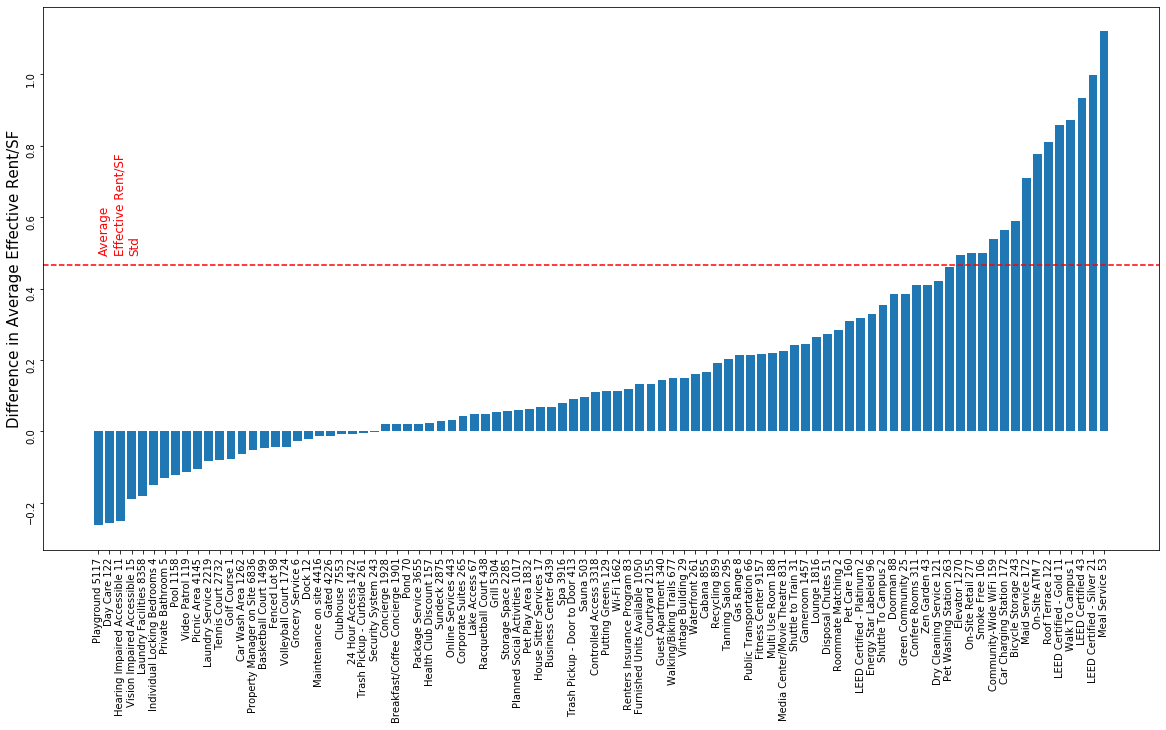

In [126]:
# Plotting rent difference with vs without amenities
test = amenity_vs_rent[amenity_vs_rent['amenity']!='Study Lounge']
xticklabel = test[['amenity','count']].apply(lambda x: x[0]+' '+str(x[1]), axis=1)

plt.figure(figsize=(20,10))
plt.bar(np.arange(test.shape[0]),
        test['diff'])
plt.xticks(np.arange(test.shape[0]),
           xticklabel,
           rotation=90)
plt.yticks(rotation=90)
plt.axhline(sub['Avg Effective/SF'].std(),
            color='red',
            linestyle='--')
plt.annotate('Average\nEffective Rent/SF\nStd', 
             (0,0.5), fontsize=12, color='red',
             rotation=90)
#plt.title('Average Effective Rent/SF With vs Without Amenity', fontsize=15)
plt.ylabel('Difference in Average Effective Rent/SF', fontsize=15)
plt.show()

#### Group Amenities
- LEED Certified - Silver, LEED Certified - Gold, LEED Certified, LEED Certified - Platinum, Energy Star Labeled
- Sports: Tennis Court, Volleyball Court, Basketball Court
- Business: Business Center, Corporate Suites, Confere Rooms, Multi Use Room
- Laundry: Laundry Facilities, Laundry Service
- Spa: Spa, Sauna
- Pet: Pet Washing Station, Pet Care, Pet Play Area
- Wifi: Community-Wide WiFi, Wi-Fi

#### + Less popular high impact amenities:
- Roof Terrace
- Maid Service
- Bicycle Storage
- Car Charging Station	
- On-Site Retail
- Elevator

#### + Top 15 popular amenities

In [127]:
# Total Amenities after grouping and adding popular amenities
amen = ['LEED Certified - Silver', 'LEED Certified - Gold', 'LEED Certified', 'LEED Certified - Platinum', 
        'Energy Star Labeled',
        # Sports
        'Tennis Court', 'Volleyball Court', 'Basketball Court',
        # Business
        'Business Center', 'Corporate Suites', 'Confere Rooms', 'Multi Use Room',
        # Laundry
        'Laundry Facilities', 'Laundry Service',
        # Spa
        'Spa', 'Sauna',
        # Pet
        'Pet Washing Station', 'Pet Care', 'Pet Play Area',
        # Wifi
        'Community-Wide WiFi', 'Wi-Fi',
        # Less popular high impact
        'Roof Terrace', 'Maid Service', 'Bicycle Storage',
        'Car Charging Station', 'On-Site Retail', 'Elevator']
top_15_amenities = amenity_vs_rent.sort_values('count', ascending=False).head(15)['amenity'].tolist()

for amenity in top_15_amenities:
    if amenity not in amen:
        amen.append(amenity)

len(amen)

38

In [128]:
# One hot encode selected amenites
# Group encoded amenities and discard original ones
for amenity in amen:
    sub['Amenity_{}'.format(amenity)] = sub['Amenities'].apply(lambda x: 1 if amenity in x.split(', ') else 0)

sub['Amenity_LEED/Energy Star'] = sub[['Amenity_LEED Certified - Silver', 
                                       'Amenity_LEED Certified - Gold', 
                                       'Amenity_LEED Certified', 
                                       'Amenity_LEED Certified - Platinum', 
                                       'Amenity_Energy Star Labeled']].max(axis=1)
sub['Amenity_Sports'] = sub[['Amenity_Tennis Court', 
                             'Amenity_Volleyball Court', 
                             'Amenity_Basketball Court']].max(axis=1)
sub['Amenity_Business'] = sub[['Amenity_Business Center', 
                               'Amenity_Corporate Suites', 
                               'Amenity_Confere Rooms', 
                               'Amenity_Multi Use Room']].max(axis=1)
sub['Amenity_Laundry'] = sub[['Amenity_Laundry Facilities', 
                              'Amenity_Laundry Service']].max(axis=1)
sub['Amenity_Spa/Sauna'] = sub[['Amenity_Spa', 
                                'Amenity_Sauna']].max(axis=1)
sub['Amenity_Pet'] = sub[['Amenity_Pet Washing Station', 
                          'Amenity_Pet Care', 
                          'Amenity_Pet Play Area']].max(axis=1)
sub['Amenity_Wifi'] = sub[['Amenity_Community-Wide WiFi', 
                           'Amenity_Wi-Fi']].max(axis=1)
cols = ['Amenity_LEED Certified - Silver', 'Amenity_LEED Certified - Gold', 'Amenity_LEED Certified', 
        'Amenity_LEED Certified - Platinum', 'Amenity_Energy Star Labeled',
        'Amenity_Tennis Court', 'Amenity_Volleyball Court', 'Amenity_Basketball Court',
        'Amenity_Business Center', 'Amenity_Corporate Suites', 
        'Amenity_Confere Rooms', 'Amenity_Multi Use Room',
        'Amenity_Laundry Facilities', 'Amenity_Laundry Service',
        'Amenity_Spa', 'Amenity_Sauna',
        'Amenity_Pet Washing Station', 'Amenity_Pet Care', 'Amenity_Pet Play Area',
        'Amenity_Community-Wide WiFi', 'Amenity_Wi-Fi']
sub.drop(columns=cols, inplace=True)

In [129]:
# Amenity vs. Avg effective/SF (when amenity is present vs. not present)
cols = ['Amenity_Roof Terrace', 'Amenity_Maid Service', 'Amenity_Bicycle Storage',
       'Amenity_Car Charging Station', 'Amenity_On-Site Retail', 'Amenity_Elevator',
       'Amenity_Fitness Center', 'Amenity_Clubhouse', 'Amenity_Property Manager on Site',
       'Amenity_Grill', 'Amenity_Playground', 'Amenity_Maintenance on site', 'Amenity_Gated',
       'Amenity_Picnic Area', 'Amenity_Package Service', 'Amenity_Controlled Access',
       'Amenity_Sundeck', 'Amenity_LEED/Energy Star', 'Amenity_Sports', 'Amenity_Business',
       'Amenity_Laundry', 'Amenity_Spa/Sauna', 'Amenity_Pet', 'Amenity_Wifi']
amenity_summary = pd.DataFrame(sub[cols].sum()).rename(columns={0:'# Properties'})
amenity_summary['% Properties'] = amenity_summary['# Properties']/sub.shape[0]*100
amenity_summary['% Properties'] = amenity_summary['% Properties'].apply(lambda x: round(x,1))
for amenity in cols:
    amenity_summary.loc[amenity, 'Avg Effective/SF w/ Amenity'] = \
    sub[sub[amenity]==1]['Avg Effective/SF'].mean()
    amenity_summary.loc[amenity, 'Avg Effective/SF w/o Amenity'] = \
    sub[sub[amenity]==0]['Avg Effective/SF'].mean()
amenity_summary['Avg Effective/SF Diff'] = amenity_summary['Avg Effective/SF w/ Amenity']-\
                                           amenity_summary['Avg Effective/SF w/o Amenity']
amenity_summary = amenity_summary.sort_values('Avg Effective/SF Diff', ascending=False)
amenity_summary

,# Properties,% Properties,Avg Effective/SF w/ Amenity,Avg Effective/SF w/o Amenity,Avg Effective/SF Diff
Amenity_Roof Terrace,122,0.9,2.048852,1.239358,0.809495
Amenity_Maid Service,172,1.3,1.946047,1.237567,0.708479
Amenity_Bicycle Storage,243,1.9,1.825021,1.235917,0.589104
Amenity_Car Charging Station,172,1.3,1.804826,1.239475,0.565350
Amenity_On-Site Retail,277,2.1,1.734549,1.236316,0.498233
Amenity_Elevator,1270,9.8,1.692252,1.198404,0.493848
Amenity_LEED/Energy Star,134,1.0,1.733433,1.241907,0.491526
Amenity_Fitness Center,9157,71.0,1.309690,1.093796,0.215894
Amenity_Wifi,1788,13.9,1.373674,1.226636,0.147038
Amenity_Controlled Access,3318,25.7,1.328327,1.218863,0.109464


# 4. Linear Regression

In [130]:
# Final list of variables considered for regression model (Base group excluded for analsysi)
cols = ['PropertyID', 'Avg Effective/SF', 
       # Property
       'Avg Concessions %', 'Vacancy %', 'Avg Unit SF', 'Year Built', 'Year Renovated', 'Star Rating', 
       'Number Of Units', 'RBA', 'Floor Area Ratio', 'Land Area (AC)', 'Number Of Stories', 
       '% 1-Bed', '% 2-Bed', '% 3-Bed', '% 4-Bed', 
       'Construction Material_Masonry', 'Construction Material_Reinforced Concrete',
       'Construction Material_Steel or Metal',
       'Owner Type_large', 'Owner Type_medium',
       'Affordable Type_Rent Restricted', 'Affordable Type_Rent Subsidized', 'Affordable Type_Affordable Units',
       # Location & Demographic
       'Closest Transit Stop Dist (mi)', '2019 Avg Age(1m)', '2019 Pop Tot', 
       'MedanHHIncome(000)', 'married %', 'male/female', 'Deposit (000s) Per Capita',
       'Supply_all', 'Supply_vacant',
       'State_GA', 'State_FL', 'State_NC',
       'City_Atlanta', 'City_Dallas', 'City_Tampa', 'City_Orlando', 'City_Miami',
       'City_Jacksonville', 'City_Tallahassee', 'City_Charlotte', 'City_Durham',
       'City_Greensboro', 'City_Raleigh', 'City_Fort Worth', 'City_San Antonio',
       'City_Austin', 'City_Houston', 'City_Arlington', 'City_El Paso', 'City_Irving', 'City_Plano',
       # Amenities
       'Amenity_Roof Terrace', 'Amenity_Maid Service', 'Amenity_Bicycle Storage',
       'Amenity_Car Charging Station', 'Amenity_On-Site Retail', 'Amenity_Elevator',
       'Amenity_Fitness Center', 'Amenity_Clubhouse', 'Amenity_Property Manager on Site',
       'Amenity_Grill', 'Amenity_Playground', 'Amenity_Maintenance on site', 'Amenity_Gated',
       'Amenity_Picnic Area', 'Amenity_Package Service', 'Amenity_Controlled Access',
       'Amenity_Sundeck', 'Amenity_LEED/Energy Star', 'Amenity_Sports', 'Amenity_Business',
       'Amenity_Laundry', 'Amenity_Spa/Sauna', 'Amenity_Pet', 'Amenity_Wifi']
final_onehot = sub[cols].copy()
final_onehot = final_onehot.fillna(0)
final_onehot.shape

(12903, 80)

### 4.1 Export for JMP

In [131]:
final_onehot.to_csv('final_onehot_1125.csv', index=False)

### 4.2 Statsmodels
- The result matches JMP result
- Further variable and outlier exclusions are done in JMP

In [132]:
test = final_onehot.copy()

In [133]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import OLSInfluence as infl

Check VIF to ensure no severe multicolinearity.

In [134]:
Xc = add_constant(test.iloc[:,2:])
vifs = [vif(Xc.values, i) for i in range(len(Xc.columns))]
pd.Series(data=vifs, index=Xc.columns).sort_values(ascending=False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const                                   47551.034684
% 1-Bed                                     9.412069
% 2-Bed                                     7.005639
Supply_vacant                               6.956090
Supply_all                                  6.868208
% 3-Bed                                     5.478698
RBA                                         4.331890
Number Of Units                             4.128782
Year Built                                  3.853151
married %                                   3.670934
Deposit (000s) Per Capita                   3.536555
State_FL                                    3.492203
City_Charlotte                              3.205380
MedanHHIncome(000)                          3.032181
Avg Unit SF                                 2.978755
% 4-Bed                                     2.934404
Star Rating                                 2.861852
State_NC                                    2.853037
Year Renovated                              2.

In [135]:
model = sm.OLS(test['Avg Effective/SF'], Xc)

In [136]:
result = model.fit()

In [137]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       Avg Effective/SF   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     160.6
Date:                Sun, 01 Dec 2019   Prob (F-statistic):               0.00
Time:                        23:32:59   Log-Likelihood:                -4033.3
No. Observations:               12903   AIC:                             8225.
Df Residuals:                   12824   BIC:                             8814.
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

# 5. Random Forest Regressor with Scikit-Learn

### 5.1 Exclude outliers identified from the regression model

In [138]:
jmp = pd.read_csv('final_onehot_1125_outlier_est_CI.dat')

In [139]:
jmp.shape

(12903, 85)

In [140]:
outlier = jmp[jmp['Outlier']==1]['PropertyID'].tolist()
len(outlier)

507

In [141]:
cols = ['PropertyID', 'Avg Effective/SF', 
       # Property
       'Avg Concessions %', 'Vacancy %', 'Avg Unit SF', 'Year Built', 'Year Renovated', 'Star Rating', 
       'Number Of Units', 'RBA', 'Floor Area Ratio', 'Land Area (AC)', 'Number Of Stories', 
       '% 1-Bed', '% 2-Bed', '% 3-Bed', '% 4-Bed', 
       'Construction Material*', 'Owner Type', 'Affordable Type*',
       # Location & Demographic
       'Closest Transit Stop Dist (mi)', '2019 Avg Age(1m)', '2019 Pop Tot',
       'MedanHHIncome(000)', 'married %', 'male/female', 'Deposit (000s) Per Capita',
       'Supply_all', 'Supply_vacant',
       'State', 'City', 'County Name',
       # Amenities
       'Amenity_Roof Terrace', 'Amenity_Maid Service', 'Amenity_Bicycle Storage',
       'Amenity_Car Charging Station', 'Amenity_On-Site Retail', 'Amenity_Elevator',
       'Amenity_Fitness Center', 'Amenity_Clubhouse', 'Amenity_Property Manager on Site',
       'Amenity_Grill', 'Amenity_Playground', 'Amenity_Maintenance on site', 'Amenity_Gated',
       'Amenity_Picnic Area', 'Amenity_Package Service', 'Amenity_Controlled Access',
       'Amenity_Sundeck', 'Amenity_LEED/Energy Star', 'Amenity_Sports', 'Amenity_Business',
       'Amenity_Laundry', 'Amenity_Spa/Sauna', 'Amenity_Pet', 'Amenity_Wifi']
sub1 = sub[-sub['PropertyID'].isin(outlier)][cols].copy()
sub1 = sub1.fillna(0)
sub1.shape

(12396, 56)

### 5.2 Regroup City, County and Affordable Type
- Make sure test subset will have enough observations in each category

In [142]:
city = sub1['City'].value_counts().reset_index()
city.columns = ['City', 'Count']
large_city = city[city['Count']>200]['City'].unique()
sub1['City**'] = sub1[['City','State']].apply(lambda x: x[0] if x[0] in large_city\
                                          else '{} Other'.format(x[1]), axis=1)
print('# City:', sub1['City**'].nunique())
print('Smallest city bin:', sub1['City**'].value_counts().tail(1))

# City: 15
Smallest city bin: Raleigh    229
Name: City**, dtype: int64


In [143]:
county = sub1['County Name'].value_counts().reset_index()
county.columns = ['County', 'Count']
large_county = county[county['Count']>200]['County'].unique()
sub1['County**'] = sub1[['County Name','State']].apply(lambda x: x[0] if x[0] in large_county\
                                          else '{} Other'.format(x[1]), axis=1)
print('# County:', sub1['County**'].nunique())
print('Smallest county bin:', sub1['County**'].value_counts().tail(1))

# County: 22
Smallest county bin: Palm Beach    201
Name: County**, dtype: int64


In [144]:
sub1['Construction Material*'].value_counts()

Wood Frame             6977
Masonry                4334
Reinforced Concrete     952
Steel or Metal          133
Name: Construction Material*, dtype: int64

Although Steel or Metal only have 134 observations, it's hard to reason combining it with any other categories, so will leave it as it is.

In [145]:
sub1['Owner Type'].value_counts()

small     7184
medium    4296
large      916
Name: Owner Type, dtype: int64

In [146]:
sub1['Affordable Type*'].value_counts()

Market              10525
Rent Restricted      1364
Rent Subsidized       418
Affordable Units       89
Name: Affordable Type*, dtype: int64

In [147]:
sub1['Affordable Type**'] = sub1['Affordable Type*'].map({'Rent Restricted':'Rent Restricted',
                                                          'Market':'Market',
                                                          'Rent Subsidized':'Rent Subsidized/Affordable Units',
                                                          'Affordable Units':'Rent Subsidized/Affordable Units'})

In [148]:
sub1['Affordable Type**'].value_counts()

Market                              10525
Rent Restricted                      1364
Rent Subsidized/Affordable Units      507
Name: Affordable Type**, dtype: int64

In [149]:
cols = ['PropertyID', 'Avg Effective/SF', 
       # Property
       'Avg Concessions %', 'Vacancy %', 'Avg Unit SF', 'Year Built', 'Year Renovated', 'Star Rating', 
       'Number Of Units', 'RBA', 'Floor Area Ratio', 'Land Area (AC)', 'Number Of Stories', 
       '% 1-Bed', '% 2-Bed', '% 3-Bed', '% 4-Bed', 
       'Construction Material*', 'Owner Type', 'Affordable Type**',
       # Location & Demographic
       'Closest Transit Stop Dist (mi)', '2019 Avg Age(1m)', '2019 Pop Tot',
       'MedanHHIncome(000)', 'married %', 'male/female', 'Deposit (000s) Per Capita',
       'Supply_all', 'Supply_vacant',
       'State', 'City**', 'County**',
       # Amenities
       'Amenity_Roof Terrace', 'Amenity_Maid Service', 'Amenity_Bicycle Storage',
       'Amenity_Car Charging Station', 'Amenity_On-Site Retail', 'Amenity_Elevator',
       'Amenity_Fitness Center', 'Amenity_Clubhouse', 'Amenity_Property Manager on Site',
       'Amenity_Grill', 'Amenity_Playground', 'Amenity_Maintenance on site', 'Amenity_Gated',
       'Amenity_Picnic Area', 'Amenity_Package Service', 'Amenity_Controlled Access',
       'Amenity_Sundeck', 'Amenity_LEED/Energy Star', 'Amenity_Sports', 'Amenity_Business',
       'Amenity_Laundry', 'Amenity_Spa/Sauna', 'Amenity_Pet', 'Amenity_Wifi']
var = sub1[cols].copy()

### 5.3 Separate train and test sets
- 0.7 train and 0.3 test to make sure test set have enough observations in each category

In [150]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(var, test_size=0.3, random_state=0)
train = train.copy()
test = test.copy()

In [151]:
print(train.shape)
print(test.shape)

(8677, 56)
(3719, 56)


### 5.4 Target encode six categorical features

In [152]:
# 'Construction Material*', 'Owner Type', 'Affordable Type**', 'State', 'City**', 'County**'

In [153]:
train['Construction Material_encoded'] = train[['Construction Material*','Avg Effective/SF']].\
                                         groupby('Construction Material*').transform(lambda x: x.mean())
test['Construction Material_encoded'] = test[['Construction Material*','Avg Effective/SF']].\
                                        groupby('Construction Material*').transform(lambda x: x.mean())
    
train['Owner Type_encoded'] = train[['Owner Type','Avg Effective/SF']].\
                              groupby('Owner Type').transform(lambda x: x.mean())
test['Owner Type_encoded'] = test[['Owner Type','Avg Effective/SF']].\
                              groupby('Owner Type').transform(lambda x: x.mean())

train['Affordable Type_encoded'] = train[['Affordable Type**','Avg Effective/SF']].\
                              groupby('Affordable Type**').transform(lambda x: x.mean())
test['Affordable Type_encoded'] = test[['Affordable Type**','Avg Effective/SF']].\
                              groupby('Affordable Type**').transform(lambda x: x.mean())

train['State_encoded'] = train[['State','Avg Effective/SF']].\
                              groupby('State').transform(lambda x: x.mean())
test['State_encoded'] = test[['State','Avg Effective/SF']].\
                              groupby('State').transform(lambda x: x.mean())

train['City_encoded'] = train[['City**','Avg Effective/SF']].\
                              groupby('City**').transform(lambda x: x.mean())
test['City_encoded'] = test[['City**','Avg Effective/SF']].\
                              groupby('City**').transform(lambda x: x.mean())

train['County_encoded'] = train[['County**','Avg Effective/SF']].\
                              groupby('County**').transform(lambda x: x.mean())
test['County_encoded'] = test[['County**','Avg Effective/SF']].\
                              groupby('County**').transform(lambda x: x.mean())

In [154]:
cols = ['Construction Material*', 'Owner Type', 'Affordable Type**', 'State', 'City**', 'County**']
train = train.drop(columns=cols)
test = test.drop(columns=cols)

In [155]:
X_train = train.iloc[:, 2:].values
y_train = train.iloc[:, 1].values
X_test = test.iloc[:, 2:].values
y_test = test.iloc[:, 1].values

### 5.5 Model fitting with 54 features

In [156]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=200, random_state=0)
regressor.fit(X_train, y_train)
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)

In [157]:
from sklearn import metrics

print('------------------------------TRAIN------------------------------')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print('R Squared:', metrics.r2_score(y_train, y_pred_train))
print('')
print('------------------------------TEST------------------------------')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('R Squared:', metrics.r2_score(y_test, y_pred_test))

------------------------------TRAIN------------------------------
Mean Absolute Error: 0.04466652068687335
Mean Squared Error: 0.00380021394260689
Root Mean Squared Error: 0.06164587530895226
R Squared: 0.9656867174194602

------------------------------TEST------------------------------
Mean Absolute Error: 0.12429448776552837
Mean Squared Error: 0.02851194776418393
Root Mean Squared Error: 0.16885481267699753
R Squared: 0.728666816991679


High Overfitting. Requires future work.

# 6. Identify Underpriced Properties

In [158]:
pred = jmp[['PropertyID', 'Avg Effective/SF', 'Pred Formula Avg Effective/SF',
            'Lower 95% Indiv Avg Effective/SF', 'Upper 95% Indiv Avg Effective/SF', 'Outlier']].copy()
pred.head()

,PropertyID,Avg Effective/SF,Pred Formula Avg Effective/SF,Lower 95% Indiv Avg Effective/SF,Upper 95% Indiv Avg Effective/SF,Outlier
0,6400737,1.46,1.265123,0.917724,1.612521,0
1,6897678,2.11,1.792363,1.444436,2.140290,0
2,6865125,2.11,1.845737,1.497319,2.194155,0
3,6900122,1.03,1.813714,1.463738,2.163691,1
4,6900121,1.63,1.763190,1.414693,2.111687,0


In [159]:
pred['Overpriced'] = pred[['Avg Effective/SF', 'Upper 95% Indiv Avg Effective/SF']].\
                     apply(lambda x: 1 if x[0]>x[1] else 0, axis=1)
pred['Underpriced'] = pred[['Avg Effective/SF', 'Lower 95% Indiv Avg Effective/SF']].\
                     apply(lambda x: 1 if x[0]<x[1] else 0, axis=1)

In [160]:
pred[['Overpriced', 'Underpriced']].sum()

Overpriced     689
Underpriced    425
dtype: int64

In [161]:
pred[pred['Outlier']==0][['Overpriced', 'Underpriced']].sum()

Overpriced     458
Underpriced    239
dtype: int64

In [162]:
underpriced = pred[(pred['Outlier']==0) & (pred['Underpriced']==1)]\
              [['PropertyID', 'Pred Formula Avg Effective/SF']]
underpriced = underpriced.merge(sub[['PropertyID', 'State', 'Latitude', 'Longitude', 'Avg Effective/SF']])
underpriced.head()

,PropertyID,Pred Formula Avg Effective/SF,State,Latitude,Longitude,Avg Effective/SF
0,9021275,1.261372,GA,33.688340,-84.505842,0.68
1,8325011,1.167366,GA,33.718105,-84.370369,0.70
2,4719499,1.118949,GA,33.667620,-84.498327,0.74
3,8077716,1.289297,GA,33.734370,-84.428340,0.92
4,8436498,1.173577,GA,33.737731,-84.403056,0.81


In [163]:
underpriced.to_csv('underpriced.csv',index=False)